In [ ]:
import os
from ultralytics import YOLO
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


def _get_non_empty_labels(label_dirs):
    res = []
    for label_dir in label_dirs:
        for label in label_dir.glob("*.txt"):
            if os.path.getsize(label) > 0:
                res.append(label)
    return res


def predict_image(model, image_path, conf_threshold=0.1):
    # Run inference
    results = model(image_path, conf=conf_threshold, verbose=False)[0]

    # Visualize
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        cls = int(box.cls[0])
        color = plt.cm.tab10(cls % 10)[:3]
        color = tuple(int(c * 255) for c in color)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 5)

    return img


def ground_truth_draw(image_path, label_path):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        for line in f:
            class_id, x_c, y_c, width, height = map(float, line.strip().split())

            # Convert back to pixel coordinates
            x1 = int((x_c - width / 2) * w)
            y1 = int((y_c - height / 2) * h)
            x2 = int((x_c + width / 2) * w)
            y2 = int((y_c + height / 2) * h)

            # Draw rectangle
            color = plt.cm.tab10((int(class_id)) % 10)[:3]
            color = tuple(int(c * 255) for c in color)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 5)
    return img


def visualize_predictions(model, dataset_dir, num_samples=6):
    """Visualize images with YOLO annotations"""
    dataset_dir = Path(dataset_dir)
    image_dir = dataset_dir / "images" / "val"
    val_labels = _get_non_empty_labels([dataset_dir / "labels" / "val"])


    # Get random samples from train set
    image_stem_by_path = {img_path.stem: img_path for img_path in image_dir.glob("*")}

    samples = random.sample(val_labels, min(num_samples, len(val_labels)))
    fig, axes = plt.subplots(len(samples), 2, figsize=(18, 12))
    # axes = axes.flatten()
    print("axresssss", len(axes), len(samples))

    idx = 0
    for label_path in samples:
        img_path = image_stem_by_path[label_path.stem]
    
        axes[idx][0].imshow(predict_image(model, img_path))
        axes[idx][0].set_title(f"P:{img_path.name}")
        axes[idx][0].axis("off")
        axes[idx][1].imshow(ground_truth_draw(img_path, label_path))
        axes[idx][1].set_title(f"T:{img_path.name}")
        axes[idx][1].axis("off")
        idx += 1


    plt.tight_layout()
    plt.show()
    print("✓ Annotated samples visualization saved")

axresssss 6 6


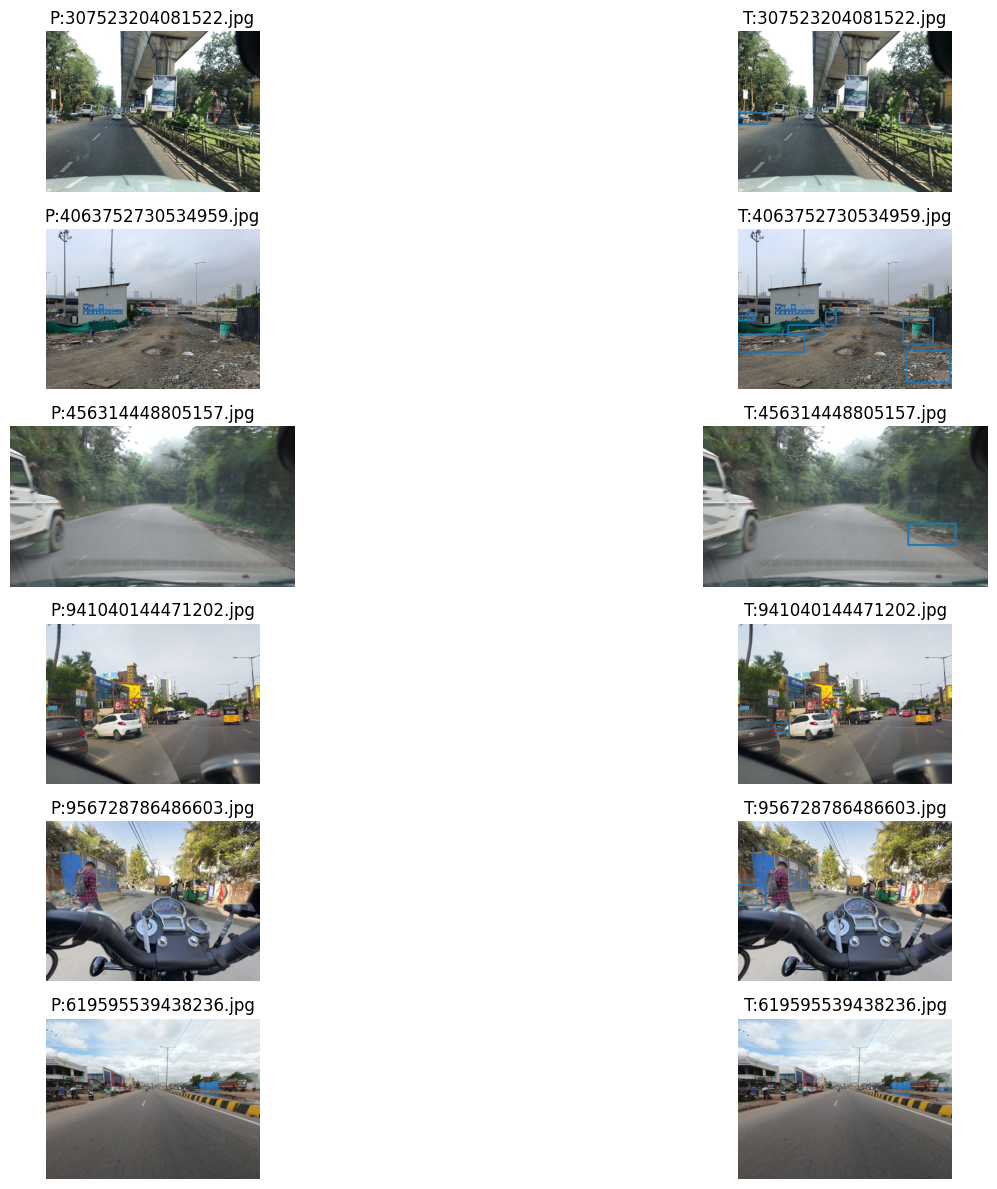

✓ Annotated samples visualization saved


In [28]:
mpath = Path(
    "/Users/hariomnarang/Desktop/gdrive-sync/yolo-train-ds/yolo_training/weights/best.pt"
)
model = YOLO(mpath)
dataset = Path("/Users/hariomnarang/Downloads/gdrive-train-template")
visualize_predictions(model, dataset)